# Simulación de curvas periódicas

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import pandas as pd
from scipy import signal

import matplotlib.pyplot as plt

from torch.utils.data import Dataset

## Generación de curvas períodicas

### Visualización de curvas

In [2]:
def plot_periodic(mjd, mag, P, ax):
    ax[0].plot(mjd, mag, '.')
    ax[0].set_xlabel('Tiempo')
    ax[1].plot(np.mod(mjd, P)/P, mag, '.')
    ax[1].set_xlabel('Fase');

### Señal cuadrada

In [3]:
def random_periodic_square_signal(period, N=100, s_noise=0.2):
    mjd = np.linspace(0, 4, num=N, dtype=np.float32)
    mjd += np.random.randn(N)*0.1
    mjd = np.sort(mjd)
    mag = signal.square(2 * np.pi * mjd/period) 
    mag += np.random.randn(N)*s_noise
    return mjd, mag

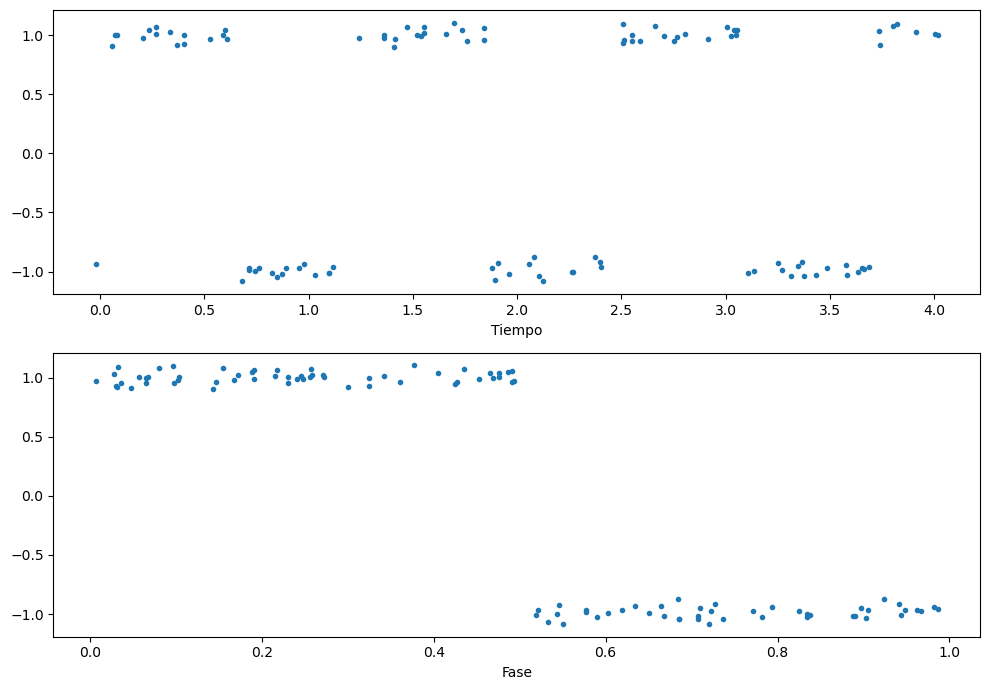

In [4]:
P = 1.234
mjd, mag = random_periodic_square_signal(P, s_noise=0.05)

fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
plot_periodic(mjd, mag, P, ax)

## Señal triangular

In [6]:
def random_periodic_sawtooth_signal(period, N=100, s_noise=0.2):
    mjd = np.linspace(0, 4, num=N, dtype=np.float32)
    mjd += np.random.randn(N)*0.1
    mjd = np.sort(mjd)
    mag = signal.sawtooth(2 * np.pi * mjd/period) 
    mag += np.random.randn(N)*s_noise
    return mjd, mag

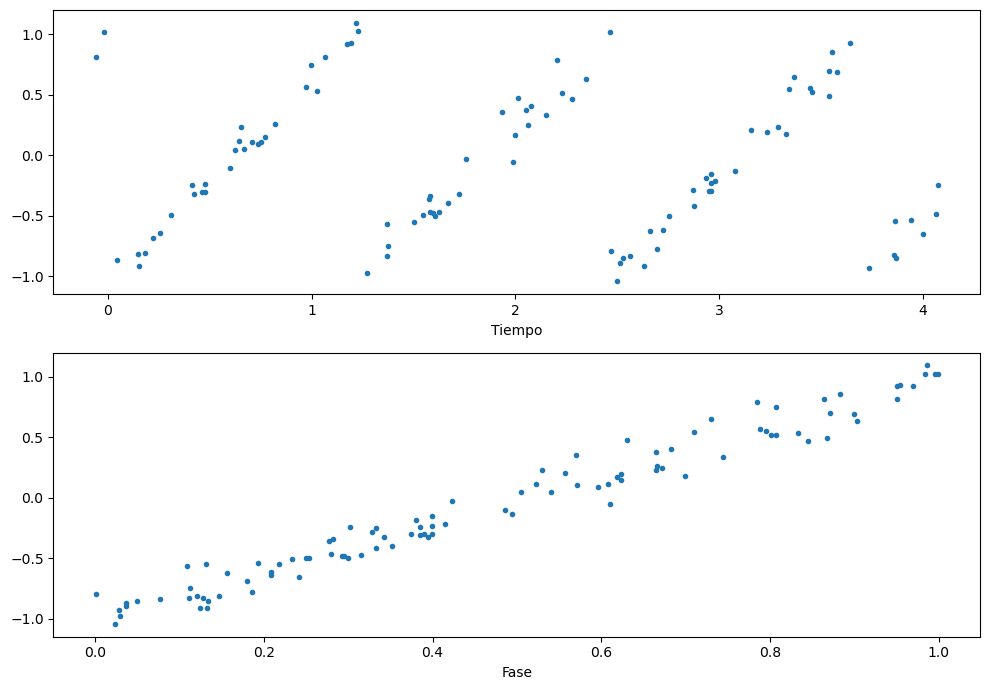

In [7]:
P = 1.234
mjd, mag = random_periodic_sawtooth_signal(P, s_noise=0.1)

fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
plot_periodic(mjd, mag, P, ax)

## Suma de sinusoides

In [10]:
def random_periodic_sin_mix(period, N=100, s_noise=0.2):

    mjd = np.linspace(0, 4, num=N, dtype=np.float32)
    mjd += np.random.randn(N)*0.1
    mjd = np.sort(mjd)
    mag = np.sin(2.0*np.pi*mjd/period) + 0.5*np.sin(2.0*np.pi*2*mjd/period)  + 0.25*np.sin(2.0*np.pi*3*mjd/period)
    mag += np.random.randn(N)*s_noise
    return mjd, mag

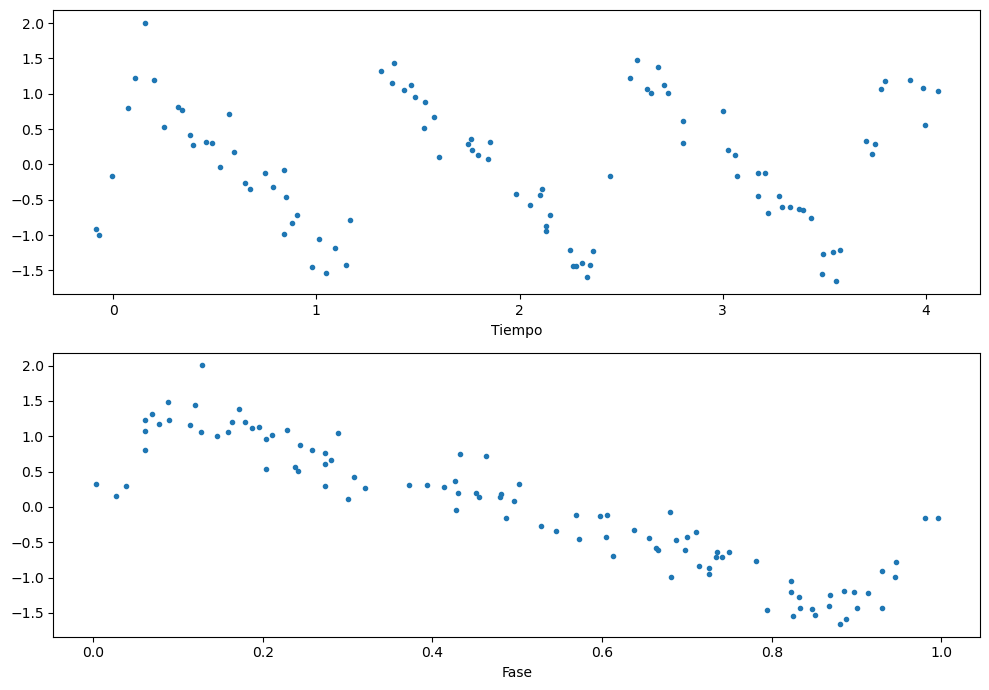

In [11]:
P = 1.234
mjd, mag = random_periodic_sin_mix(P)

fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
plot_periodic(mjd, mag, P, ax)

## Adaptación a dataset de Pytorch

### Dataset class

In [101]:
class lc_dataset(Dataset):
    def __init__(self, seed=42):
        # Set seed
        self.seed = seed
        np.random.seed(self.seed)

        # Generators
        self.curve_generators = {'square': random_periodic_square_signal,
                                'sawtooth': random_periodic_sawtooth_signal,
                                'sinmix': random_periodic_sin_mix}

        # Curve data
        self.period_list = []
        self.mjd_list = []
        self.mag_list = []
        self.labels = []

    def generate_periods(self, N, min_period, max_period):
        """Genera una lista de períodos random.

        Parameters
        ----------
        N : int
            Número int que define la cantidad de períodos a generar.
        min_period : float
            float que define el mínimo valor posible a generar.
        max_period : float
            float que define el máximo valor posible a generar.

        Returns
        -------
        np.ndarray
            np.ndarray con el arreglo de períodos generados.            
        """
        random_period_list = []
        for idx in range(N):
            random_period = np.random.uniform(min_period, max_period)
            random_period_list.append(random_period)
        return random_period_list
        
    def add_curves(self, curve_type, N, min_period, max_period, label):
        """Añade N curvas de un determinado tipo al dataset.

        Parameters
        ----------
        curve_type : str
            str que define el tipo de curvas a generar.
        N : int
            Número int que define la cantidad de períodos a generar.            
        min_period : float
            float que define el mínimo valor posible a generar.
        max_period : float
            float que define el máximo valor posible a generar.
        label : int
            int que define el label que tendrán las curvas generadas.            
        """
        period_list = self.generate_periods(N, min_period, max_period)
        self.period_list += period_list
        for period in period_list:
            mjd, mag = self.curve_generators[curve_type](period, N=N)
            self.mjd_list.append(mjd)
            self.mag_list.append(mag)
            self.labels.append(label)

    def to_df(self):
        """Transforma los datos generados en un Pandas DataFrame.

        Returns
        -------
        pd.DataFrame
            pd.DataFrame con los datos generados.            
        """        
        dataset_df = pd.DataFrame({'mjd':self.mjd_list,
                                    'mag':self.mag_list,
                                    'period':self.period_list,
                                    'label':self.labels})
        return dataset_df

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        curve_dict = {'mjd':self.mjd_list[idx],
                    'mag':self.mag_list[idx],
                    'period':self.period_list[idx],}
        return curve_dict

### Prueba

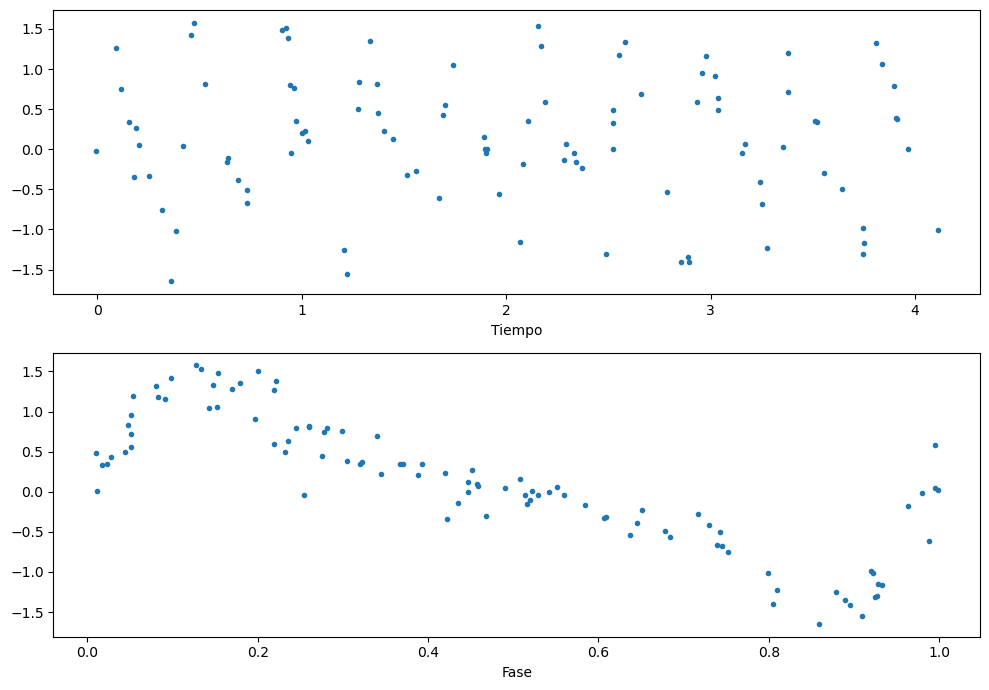

In [125]:
dataset = lc_dataset()
dataset.add_curves('sinmix', 100, 0.2, 2, 0)

fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
obj_id = 40
plot_periodic(*dataset.to_df().loc[obj_id].values[:-1], ax)

In [126]:
dataset.add_curves('sawtooth', 100, 5, 10, 1)
dataset.to_df()

,mjd,mag,period,label
0,"[-0.07754476, 0.008704707, 0.010503305, 0.0899...","[-1.2239591, 0.46228376, 0.1538344, 1.8606755,...",0.874172,0
1,"[-0.019617647, 0.01990597, 0.08268076, 0.08778...","[-0.0023624094, 0.21607804, 1.1470501, 0.58618...",1.911286,0
2,"[0.057655696, 0.07152905, 0.081779614, 0.10646...","[0.67743087, 0.9191666, 0.5622052, 1.283612, 1...",1.517589,0
3,"[-0.11105759, 0.08911502, 0.17437592, 0.189972...","[-1.3581426, 1.0009868, 1.3708396, 1.4893783, ...",1.277585,0
4,"[-0.05176113, 0.06278284, 0.079165794, 0.14893...","[-1.4287921, 0.90269285, 0.9915818, 0.6338268,...",0.480834,0
...,...,...,...,...
195,"[-0.06037448, -0.021978624, 0.080224425, 0.214...","[1.134834548725925, 0.8083569393507781, -1.136...",8.676480,1
196,"[-0.026268579, 0.05686235, 0.07704073, 0.09226...","[0.8285063738997064, -1.0597885820073645, -1.1...",8.017504,1
197,"[-0.11325406, -0.0041802935, 0.11295654, 0.115...","[1.1842771276361852, 1.2439456637078774, -0.45...",8.268147,1
198,"[0.042412084, 0.057044663, 0.06735375, 0.07047...","[-1.0871041407570774, -0.962327988055821, -0.8...",6.052919,1
